In [ ]:
# choose env = research

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

from micrograd.engine import Value
from micrograd.nn import MLP

np.random.seed(37)
random.seed(37)
%matplotlib inline

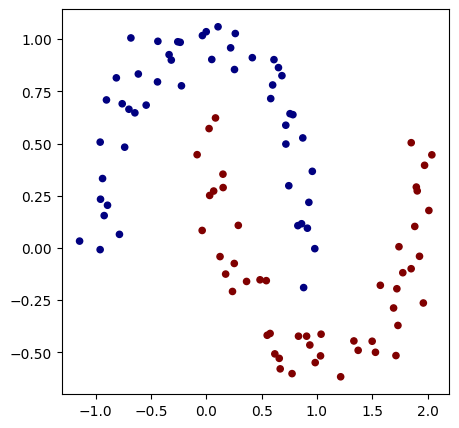

In [ ]:
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, noise=0.1, random_state=37)

y = y*2 - 1

plt.figure(figsize=(5, 5))
plt.scatter(x[:, 0], x[:, 1], c=y, s=20, cmap="jet")

In [3]:
model = MLP(nin=2, nouts=[32, 16, 16, 1])
print(f"total parms: {len(model.parameters())}")
print(model)

total parms: 913
MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32), ReLUNeuron(32)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16),

In [4]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        xb, yb = x, y
    else:
        ri = np.random.permutation(x.shape[0])[:batch_size]
        xb, yb = x[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=2.9483037346047802, grad=0.0) 0.28


In [5]:
epochs = 5
for k in range(epochs):
    # forward pass
    total_loss, acc = loss()
    
    # backward pass
    model.zero_grad()
    total_loss.backward()
    
    # update: sgd
    lr = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= lr * p.grad
    
    if k % 1 == 0:
        print(f"step: {k} | loss: {total_loss.data:.4f}, accuracy: {acc:.4f}")

step: 0 | loss: 2.9483, accuracy: 0.2800
step: 1 | loss: 2.9505, accuracy: 0.2800
step: 2 | loss: 2.9527, accuracy: 0.2800
step: 3 | loss: 2.9548, accuracy: 0.2800
step: 4 | loss: 2.9570, accuracy: 0.2800


(-1.6171382427779721, 1.8828617572220279)

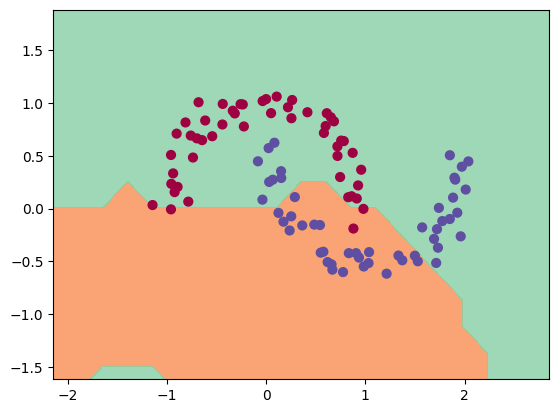

In [6]:
# visualize decision boundary

h = 0.25
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs = [list(map(Value, xrow)) for xrow in xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
